Using python (scipy.signal) to extract peaks

Then saving peak information as .csv files to open in R for statistical analysis

In [1]:
import scipy
import os
import numpy as np
import pandas as pd
import skimage as sk
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
# set plot defaults
import matplotlib as mpl
import math

Read in files as a dictionary that contains the session as keys and arrays of fluorescence as values

In [2]:
animal = 'LS6_morphine'

In [3]:
dir_data = r'C:\Users\stuberadmin\Documents\2p_analysis_20220217\Day0-14_analysis\Suite2p_output'
dir_folders = os.listdir(os.path.join(dir_data, animal))
save_dir = r'C:\Users\stuberadmin\Documents\2p_analysis_20220217\Day0-14_analysis\Spontaneous_activity_analysis'

In [4]:
save_dir

'C:\\Users\\stuberadmin\\Documents\\2p_analysis_20220217\\Day0-14_analysis\\Spontaneous_activity_analysis'

In [5]:
F_dict = dict()
Fneu_dict = dict()

for folder in dir_folders:
    if folder.endswith('_baseline'):
        os.chdir(os.path.join(dir_data, animal, folder))
        for file in os.listdir():
            if file.endswith('F.npy'):
                 F_dict[folder.split('_')[0]] = np.load(file)
            if file.endswith('Fneu.npy'):
                 Fneu_dict[folder.split('_')[0]] = np.load(file)

In [6]:
#Fcor_dict = {key: F_dict[key] - Fneu_dict.get(key, 0) for key in F_dict}

Read in a dataframe containing the ROI identities across all sessions

In [7]:
#Load in tracking arrays as a dict with the same key names as Fcor_dict
#Pay attention to which tracking dataframe is being used
Track_df = pd.read_excel(r'C:\Users\stuberadmin\Documents\2p_analysis_20220217\Day0-14_analysis\Manual_track_ROIs_v3_checked_subset-for-days-0-14.xlsx', sheet_name = animal, index_col=0)
Day_dict = {
  "Day0": Track_df['Day0_baseline'].to_numpy(),
  "Day2": Track_df['Day2_baseline'].to_numpy(),
  "Day4": Track_df['Day4_baseline'].to_numpy(),
  "Day6": Track_df['Day6_baseline'].to_numpy(),
#  "Day7-pre": Track_df['Day7-pre'].to_numpy(),
#  "Day7-post": Track_df['Day7-post'].to_numpy(),
#  "Day7-end": Track_df['Day7-end'].to_numpy(),
  "Day14":Track_df['Day14_baseline'].to_numpy() 
}

In [8]:
#Sorting the dictionary so that the cells are the same index across all sessions
F_dict_sub = dict()
for key in F_dict:
    F_dict_sub[key] = F_dict[key][Day_dict[key]]

In [9]:
#Sorting the dictionary so that the cells are the same index across all sessions
#Fcor_dict_sub = dict()
#for key in Fcor_dict:
#    Fcor_dict_sub[key] = Fcor_dict[key][Day_dict[key]]

Performing a baseline correction on the data

In [10]:
def nPolyCorrect(arr, degree):
    x = list(range(len(arr)))
    fit = np.polyfit(x = x, y = arr, deg = degree)
    fit = np.poly1d(fit)
    pplot, = plt.plot(x, fit((x)))
    pdata = pplot.get_ydata()
    return arr - pdata

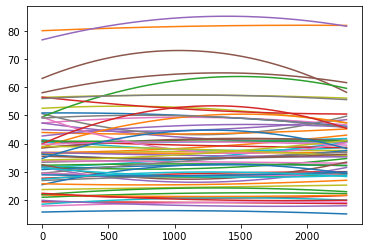

In [11]:
#Performing a baseline correction
Bl_correct_dict = dict()
Bl_correct_list = list()

for key in F_dict_sub:
    for i in F_dict_sub[key]:
        cor = nPolyCorrect(i, 2)
        Bl_correct_list.append(cor)
    Bl_correct_dict[key] = Bl_correct_list
    Bl_correct_list = list()

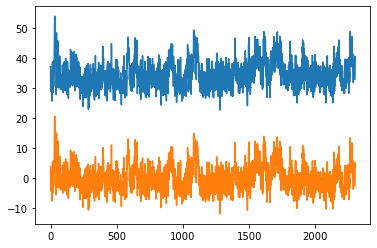

In [12]:
plt.plot(F_dict_sub['Day0'][7])
plt.plot(Bl_correct_dict['Day0'][7])

Taking a rolling average to smooth the data

In [13]:
#Defining a function to take the rolling mean of a given array
def rolling_average(arr, window_size):

    # Program to calculate moving average
    i = 0
    # Initialize an empty list to store moving averages
    rolled_average = []
  
    # Loop through the array to consider
    # every window of size 10
    while i < len(arr) - window_size + 1:
    
        # Store elements from i to i+window_size
        # in list to get the current window
        window = arr[i : i + window_size]
  
        # Calculate the average of current window
        window_average = round(sum(window) / window_size, 2)
      
        # Store the average of current
        # window in moving average list
        rolled_average.append(window_average)
      
        # Shift window to right by one position
        i += 1
        
    return rolled_average

In [14]:
#Performing rolling mean on previous dictionary
Rolled_dict = dict()
rolled_list = list()

for key in Bl_correct_dict:
    for i in Bl_correct_dict[key]:
        rolled = rolling_average(i, 20)
        rolled_list.append(rolled)
    Rolled_dict[key] = rolled_list
    rolled_list = list()

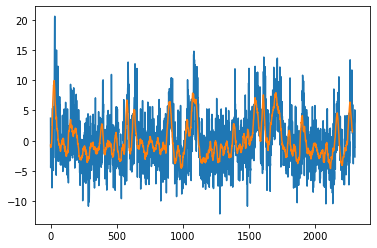

In [15]:
plt.plot(Bl_correct_dict['Day0'][7])
plt.plot(Rolled_dict['Day0'][7])

In [16]:
from scipy import stats

In [17]:
#Normalizing the data by Z Scoring it
Zscore_dict = dict()
Zscore_list = list()

for key in Rolled_dict:
    for i in Rolled_dict[key]:
        zscored = stats.zscore(i)
        Zscore_list.append(zscored)
    Zscore_dict[key] = Zscore_list
    Zscore_list = list()

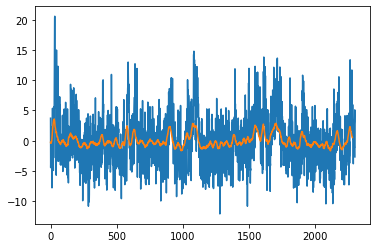

In [18]:
plt.plot(Bl_correct_dict['Day0'][7])
plt.plot(Zscore_dict['Day0'][7])

In [19]:
from scipy.signal import butter, lfilter, freqz
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [20]:
# Setting parameters for generating a lowpass filter
order = 6
fs = 7.5
#cutoff = 0.3
cutoff = 0.8
b, a = butter_lowpass(cutoff, fs, order)

In [21]:
Filtered_dict = dict()
Filtered_list = list()

for key in Zscore_dict:
    for i in Zscore_dict[key]:
        order = 6
        filtered = butter_lowpass_filter(i, cutoff, fs, order)
        #Cascading butterworth filter to correct for the time lag introduced by the first one
        order = 5
        filtered2 = butter_lowpass_filter(np.flip(filtered), cutoff,fs,order)
        Filtered_list.append(np.flip(filtered2))
    Filtered_dict[key] = Filtered_list
    Filtered_list = list()

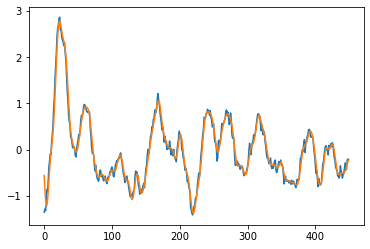

In [22]:
plt.plot(Zscore_dict['Day0'][3][0:450])
plt.plot(Filtered_dict['Day0'][3][0:450])

In [23]:
peakwidth_dict = dict()
peakheight_dict = dict()
peaktime_dict = dict()

peak_count_df = pd.DataFrame()
peak_amp_mean_df = pd.DataFrame()
peak_wid_mean_df = pd.DataFrame()

width_list = list()
height_list = list()
peak_list = list()
width_mean = list()
height_mean = list()
peak_count = list()

for key in Filtered_dict:
    for i in Filtered_dict[key]:
        peaks = scipy.signal.find_peaks(i)
        width = scipy.signal.peak_widths(i, peaks = peaks[0], rel_height=1)
        height = scipy.signal.peak_prominences(i, peaks = peaks[0])
        
        width_mean.append(np.mean(width[0]))
        height_mean.append(np.mean(height[0]))
        peak_list.append(peaks[0])
        peak_count.append(len(peaks[0]))
        
        width_list.append(width[0]) 
        height_list.append(height[0])
    
    peakwidth_dict[key] = width_list
    peakheight_dict[key] = height_list
    peaktime_dict[key] = peak_list
    
    peak_count_df[key] = peak_count
    peak_amp_mean_df[key] = height_mean
    peak_wid_mean_df[key] = width_mean

    width_mean = list()
    height_mean = list()
    peak_list = list()
    peak_count = list()
    width_list = list()
    height_list = list()

In [24]:
x = Filtered_dict['Day0'][4][0:900]

In [25]:
peaks = scipy.signal.find_peaks(x)[0]

In [26]:
heights = scipy.signal.peak_prominences(x, peaks)

In [27]:
widths = scipy.signal.peak_widths(x, rel_height = 1, peaks = scipy.signal.find_peaks(x)[0])

In [28]:
print(scipy.signal.peak_prominences(x, peaks)[1])
print(scipy.signal.peak_prominences(x, peaks)[2])

[  4  76 119 119 175 199 208 231 231 231 231 349 231 409 469 518 518 469
 469 672 696 720 762 775 782 831 860 720]
[469 231 149 231 231 231 231 252 266 296 349 376 469 469 518 546 561 608
 720 720 720 831 782 782 831 871 871 899]


In [29]:
heights = scipy.signal.peak_prominences(x, peaks)[0]

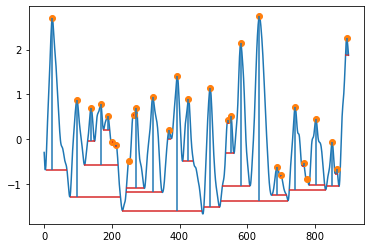

In [30]:
contour_heights = x[peaks] - heights
plt.plot(Filtered_dict['Day0'][4][0:900])
plt.plot(peaks, x[peaks], "o")
plt.hlines(*widths[1:], color="C3")
plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])

In [31]:
peak_wid_mean_df.mean(axis=0)

Day0     55.543949
Day14    74.511653
Day2     62.817144
Day4     58.100647
Day6     55.303853
dtype: float64

In [32]:
peak_amp_mean_df.mean(axis=0)

Day0     0.705431
Day14    0.801617
Day2     0.752926
Day4     0.680532
Day6     0.615639
dtype: float64

In [33]:
peak_count_df.mean(axis=0)

Day0     84.307692
Day14    76.692308
Day2     78.538462
Day4     84.153846
Day6     87.153846
dtype: float64

In [34]:
F_dict_sub['Day4'][2]

array([45.832634, 46.2841  , 41.907654, ..., 48.01819 , 50.162766,
       47.503468], dtype=float32)

In [35]:
peak_count_df = peak_count_df[['Day0', 'Day2', 'Day4', 'Day6', 'Day14']]

In [36]:
peak_wid_mean_df = peak_wid_mean_df[['Day0', 'Day2', 'Day4', 'Day6', 'Day14']]

In [37]:
peak_amp_mean_df = peak_amp_mean_df[['Day0', 'Day2', 'Day4', 'Day6', 'Day14']]

In [38]:
os.chdir(save_dir)

In [39]:
peak_count_df.to_csv("peak_count_df_" + animal + "_cutoff-is-08-height-is-1.csv",sep=',')
peak_wid_mean_df.to_csv("peak_width_df_" + animal + "_cutoff-is-08-height-is-1.csv",sep=',')
peak_amp_mean_df.to_csv("peak_amp_df_" + animal + "_cutoff-is-08-height-is-1.csv",sep=',')